In [20]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
import glob
import os

In [21]:
nc_files = sorted( glob.glob( r"C:\Users\locfa_v05v5qi\Documents\escadas_termohalinas\raw\Dataset\**\*.nc", recursive=True ) )

In [22]:
def subset_region(ds):
    # Ajustar longitudes se estiverem em 0–360
    if ds.lon.max() > 180:
        ds = ds.assign_coords(
            lon=((ds.lon + 180) % 360) - 180
        )

    # Criar máscara apenas para a dimensão n (perfis)
    mask = (
        (ds.lat <= 10) & (ds.lat >= -60) &
        (ds.lon >= -50) & (ds.lon <= -10)
    )

    if "Nobs" in ds.dims:
        ds = ds.isel(Nobs=mask)

    return ds
    
def check_staircase_exists(ml_h, gl_h): #verifica se os valores são fisicamente válidos (n só se existem)

    valid_ml = np.sum(~np.isnan(ml_h) & (ml_h > 0))
    valid_gl = np.sum(~np.isnan(gl_h) & (gl_h > 0))

    return (valid_ml >= 1) and (valid_gl >= 1)
    
def detect_staircases(ds):

    profile_dim = ds.lat.dims[0]
    n_profiles = ds.sizes[profile_dim] #p n ter problema d confundir "n" e "Nobs"

    staircase_sf = np.zeros(n_profiles, dtype=bool)
    staircase_dc = np.zeros(n_profiles, dtype=bool)

    for i in range(n_profiles):

        # =========================
        # SALT FINGER
        # =========================
        ml_mask_sf = ds.mask_ml_sf_layer.isel({profile_dim: i}) > 0
        gl_mask_sf = ds.mask_gl_sf_layer.isel({profile_dim: i}) > 0

        ml_h_sf = ds.ml_h.isel({profile_dim: i}).values[ml_mask_sf.values] #pega os valores onde ml_mask_sf é True 
        gl_h_sf = ds.gl_h.isel({profile_dim: i}).values[gl_mask_sf.values]

        if len(ml_h_sf) > 0 and len(gl_h_sf) > 0:
            staircase_sf[i] = check_staircase_exists(
                ml_h_sf, gl_h_sf
            )

        # =========================
        # DIFFUSIVE CONVECTION
        # =========================
        ml_mask_dc = ds.mask_ml_dc_layer.isel({profile_dim: i}) > 0
        gl_mask_dc = ds.mask_gl_dc_layer.isel({profile_dim: i}) > 0

        ml_h_dc = ds.ml_h.isel({profile_dim: i}).values[ml_mask_dc.values]
        gl_h_dc = ds.gl_h.isel({profile_dim: i}).values[gl_mask_dc.values]

        if len(ml_h_dc) > 0 and len(gl_h_dc) > 0:
            staircase_dc[i] = check_staircase_exists(
                ml_h_dc, gl_h_dc
            )

    ds["staircase_sf"] = (profile_dim, staircase_sf)
    ds["staircase_dc"] = (profile_dim, staircase_dc)

    return ds

In [52]:
# =========================================================
# CONTADORES GERAIS
# =========================================================

total_profiles = 0
total_profiles_region = 0
total_profiles_stair = 0

total_profiles_sf = 0
total_profiles_dc = 0
total_profiles_mixed = 0

# Estatísticas verticais
all_ml_depth_sf = []
all_ml_depth_dc = []

all_ml_thickness_sf = []
all_ml_thickness_dc = []

n_layers_sf = []
n_layers_dc = []

# Pontos espaciais
all_points = []
all_points_stair = []
all_points_sf = []
all_points_dc = []
all_points_mixed = []

results = []

# =========================================================
# LOOP PRINCIPAL
# =========================================================

for file in nc_files:

    print(f"\nProcessando: {os.path.basename(file)}")

    ds = xr.open_dataset(file)

    # ---------------- PERFIS GLOBAIS ----------------
    n_global = ds.sizes.get("Nobs", 0)
    total_profiles += n_global
    print("Perfis globais:", n_global)

    # ---------------- RECORTE ----------------
    ds = subset_region(ds)
    
    n_region = ds.sizes.get("Nobs", 0)
    total_profiles_region += n_region
    print("Perfis na região:", n_region)
    
    if n_region == 0:
        continue

    # ---------------- DETECÇÃO ----------------
    ds = detect_staircases(ds)

    sf_mask = ds.staircase_sf #array booleano por perfil
    dc_mask = ds.staircase_dc
    stair_mask = (sf_mask | dc_mask) #total de perfis
    mixed_mask = (sf_mask & dc_mask)

    n_sf = int(sf_mask.sum())
    n_dc = int(dc_mask.sum())
    n_mixed = int(mixed_mask.sum())
    n_stair = int(stair_mask.sum())

    total_profiles_sf += n_sf
    total_profiles_dc += n_dc
    total_profiles_mixed += n_mixed
    total_profiles_stair += n_stair

    # ---------------- PONTOS ESPACIAIS ----------------

    lat = ds.lat.values
    lon = ds.lon.values

    lat_round = np.round(lat, 2)
    lon_round = np.round(lon, 2)

    for la, lo in zip(lat_round, lon_round):
        all_points.append((lo, la))

    for la, lo in zip(lat_round[stair_mask.values],
                      lon_round[stair_mask.values]):
        all_points_stair.append((lo, la))

    for la, lo in zip(lat_round[sf_mask.values],
                      lon_round[sf_mask.values]):
        all_points_sf.append((lo, la))

    for la, lo in zip(lat_round[dc_mask.values],
                      lon_round[dc_mask.values]):
        all_points_dc.append((lo, la))

    for la, lo in zip(lat_round[mixed_mask.values],
                      lon_round[mixed_mask.values]):
        all_points_mixed.append((lo, la))

    subset = ds[[
        "lat",
        "lon",
        "juld",
        "staircase_sf",
        "staircase_dc"
    ]]

    results.append(subset)


# =========================================================
# RESULTADOS FINAIS
# =========================================================

unique_points = set(all_points)
unique_points_stair = set(all_points_stair)
unique_points_sf = set(all_points_sf)
unique_points_dc = set(all_points_dc)
unique_points_mixed = set(all_points_mixed)

print("\n================ RESULTADOS ==================")

print("\n----- PERFIS -----")
print("Perfis globais:", total_profiles)
print("Perfis na região:", total_profiles_region)
print("Perfis com escada:", total_profiles_stair)
print("Perfis SF:", total_profiles_sf)
print("Perfis DC:", total_profiles_dc)
print("Perfis mistos:", total_profiles_mixed)

if total_profiles_region > 0:
    print("\nFrequência total de escadas:",
          round(100 * total_profiles_stair / total_profiles_region, 2), "%")

print("\n----- PONTOS ÚNICOS -----")
print("Pontos únicos na região:", len(unique_points))
print("Pontos únicos com escada:", len(unique_points_stair))
print("Pontos únicos SF:", len(unique_points_sf))
print("Pontos únicos DC:", len(unique_points_dc))
print("Pontos únicos mistos:", len(unique_points_mixed))

if len(unique_points) > 0:
    freq_spatial = len(unique_points_stair) / len(unique_points)
    print("Frequência espacial total:",
          round(freq_spatial * 100, 2), "%")





Processando: argo_00000000_00000249.nc
Perfis globais: 4
Perfis na região: 0

Processando: argo_00000250_00000499.nc
Perfis globais: 40
Perfis na região: 0

Processando: argo_00000500_00000749.nc
Perfis globais: 827
Perfis na região: 0

Processando: argo_00000750_00000999.nc
Perfis globais: 367
Perfis na região: 22

Processando: argo_00001000_00001249.nc
Perfis globais: 3017
Perfis na região: 198

Processando: argo_00001250_00001499.nc
Perfis globais: 3591
Perfis na região: 524

Processando: argo_00001500_00001749.nc
Perfis globais: 25540
Perfis na região: 6356

Processando: argo_00001750_00001999.nc
Perfis globais: 8247
Perfis na região: 1311

Processando: argo_00002000_00002249.nc
Perfis globais: 24
Perfis na região: 0

Processando: argo_00002250_00002499.nc
Perfis globais: 811
Perfis na região: 0

Processando: argo_00002500_00002749.nc
Perfis globais: 142
Perfis na região: 0

Processando: argo_00002750_00002999.nc
Perfis globais: 2786
Perfis na região: 0

Processando: argo_00003000

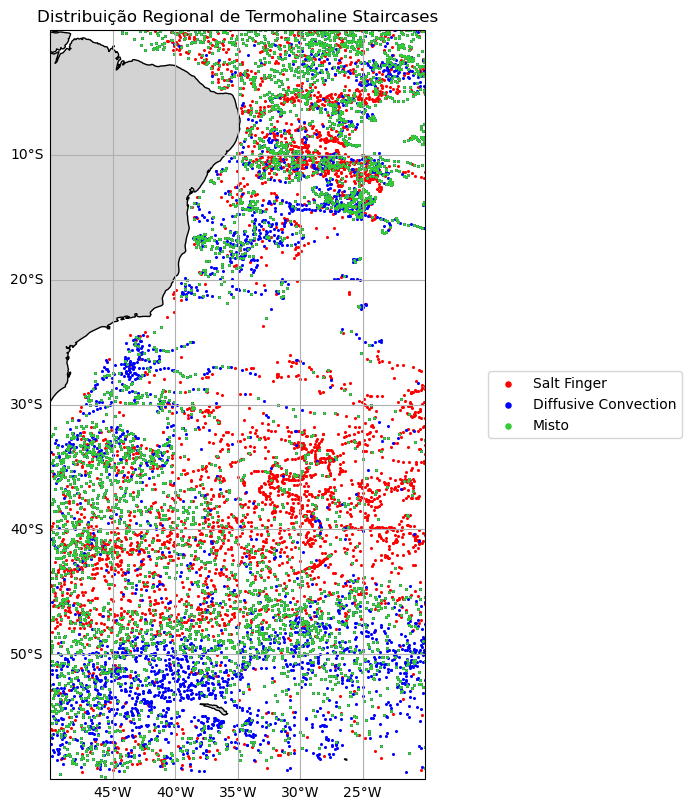

In [53]:
# ---------------------------------------------------------
# Converter sets para listas separadas
# (assumindo que cada ponto é (lon, lat))
# ---------------------------------------------------------

all_lons, all_lats = zip(*unique_points) if unique_points else ([], [])

sf_lons, sf_lats = zip(*unique_points_sf) if unique_points_sf else ([], [])
dc_lons, dc_lats = zip(*unique_points_dc) if unique_points_dc else ([], [])
mixed_lons, mixed_lats = zip(*unique_points_mixed) if unique_points_mixed else ([], [])

# ---------------------------------------------------------
# Plot
# ---------------------------------------------------------

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-50, -20, -60, 0], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# ---------------------------------------------------------
# 2️⃣ Sobrepor regimes
# ---------------------------------------------------------

ax.scatter(
    sf_lons, sf_lats,
    color='red',
    s=1.5,
    transform=ccrs.PlateCarree(),
    label='Salt Finger'
)

ax.scatter(
    dc_lons, dc_lats,
    color='blue',
    s=1.5,
    transform=ccrs.PlateCarree(),
    label='Diffusive Convection'
)

ax.scatter(
    mixed_lons, mixed_lats,
    color='limegreen',
    s=1.5,
    transform=ccrs.PlateCarree(),
    label='Misto'
)

# Legenda externa
ax.legend(
    loc="center left",
    bbox_to_anchor=(1.15, 0.5),
    markerscale=3
)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.title("Distribuição Regional de Termohaline Staircases")
plt.show()
